# 🧠 UMAP Visualization: Model Embeddings vs Raw Features

## Goal
Compare learned representations from a trained neural network with raw input features:
1. Train a model on UNSW-NB15 
2. Extract penultimate-layer embeddings (32-dim from fc3 layer)
3. Run UMAP on embeddings
4. Compare with UMAP on raw features

This helps us understand if the model learned better separations than raw features.

In [34]:
# Setup: Ensure repo root is on sys.path
from pathlib import Path
import os
import sys

repo_root = Path.cwd()
if repo_root.name == "notebooks":
    repo_root = repo_root.parent

os.chdir(repo_root)
sys.path.insert(0, str(repo_root))

print("Repo root:", repo_root)

Repo root: /home/e20094/e20-4yp-backdoor-resilient-federated-nids


In [35]:
# Set all random seeds for reproducibility
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"🎲 All random seeds set to {SEED} for reproducibility")

🎲 All random seeds set to 42 for reproducibility


In [36]:
import warnings
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pathlib import Path
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Import model and utilities
from src.client.model import Net
from src.utils.class_weights import get_class_weights

## Step 1: Preprocess Data (if needed)

In [37]:
# Check if preprocessed data exists, if not create it
train_path = Path("data/unsw-nb15/processed/train_pool.pt")
test_path = Path("data/unsw-nb15/processed/global_test.pt")

if not train_path.exists() or not test_path.exists():
    print("🔄 Preprocessing data...")
    from src.data.preprocess import clean_and_process
    clean_and_process()
    print("✅ Preprocessing complete!")
else:
    print("✅ Preprocessed data found!")

✅ Preprocessed data found!


## Step 2: Load Configuration & Data

In [38]:
# Load config from m7_moderate_weights.yaml and its base config
config_path = Path("configs/central/m7_moderate_weights.yaml")
base_config_path = Path("configs/central/m1_baseline.yaml")

with open(base_config_path, 'r') as f:
    config = yaml.safe_load(f)

# Override with m7 settings
with open(config_path, 'r') as f:
    m7_config = yaml.safe_load(f)
    config.update(m7_config)

print("📋 Configuration:")
print(f"  - Batch size: {config['batch_size']}")
print(f"  - Epochs: {config['epochs']}")
print(f"  - Learning rate: {config['lr']}")
print(f"  - Use class weights: {config['use_class_weights']}")
print(f"  - Weight method: {config.get('weight_method', 'inverse')}")
print(f"  - Input dim: {config['input_dim']}")
print(f"  - Num classes: {config['num_classes']}")

📋 Configuration:
  - Batch size: 128
  - Epochs: 20
  - Learning rate: 0.001
  - Use class weights: True
  - Weight method: sqrt
  - Input dim: 71
  - Num classes: 10


In [39]:
# Load preprocessed data
print("📂 Loading data...")
train_data = torch.load(train_path, weights_only=False)
test_data = torch.load(test_path, weights_only=False)

# Handle both dict and TensorDataset formats
if isinstance(train_data, dict):
    X_train, y_train = train_data['X'], train_data['y']
    label_map = train_data.get('label_map', {})
else:
    X_train, y_train = train_data.tensors[0], train_data.tensors[1]
    label_map = {}

if isinstance(test_data, dict):
    X_test, y_test = test_data['X'], test_data['y']
else:
    X_test, y_test = test_data.tensors[0], test_data.tensors[1]

# Create inverse label map for visualization
inv_label_map = {v: k for k, v in label_map.items()} if label_map else {}

print(f"✅ Train: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"✅ Test: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
print(f"📊 Classes: {sorted(inv_label_map.values()) if inv_label_map else list(range(config['num_classes']))}")

📂 Loading data...
✅ Train: 206,138 samples, 71 features
✅ Test: 51,535 samples, 71 features
📊 Classes: ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']


## Step 3: Train the Model

In [40]:
# Setup device and model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Device: {device}")

# Initialize model
input_dim = X_train.shape[1]
num_classes = config['num_classes']
model = Net(input_dim=input_dim, num_classes=num_classes).to(device)

print(f"🏗️ Model architecture:")
print(model)
print(f"\n📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

💻 Device: cuda
🏗️ Model architecture:
Net(
  (fc1): Linear(in_features=71, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

📊 Model parameters: 19,882


In [41]:
# Setup loss function and optimizer
if config.get('use_class_weights', False):
    print("⚖️ Computing class weights...")
    weight_method = config.get('weight_method', 'inverse')
    class_weights = get_class_weights(y_train, device, method=weight_method)
    print(f"   Method: {weight_method}")
    print(f"   Weights: {class_weights.cpu().numpy()}")
    criterion = nn.CrossEntropyLoss(weight=class_weights)
else:
    print("📉 Using standard CrossEntropyLoss (no class weights)")
    criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=config['lr'])

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"\n✅ Training setup complete!")

⚖️ Computing class weights...
⚖️ Calculated Class Weights (sqrt): [ 0.53  3.1   3.33  1.26  0.76  1.03  0.66  1.36  4.13 10.  ]
   Method: sqrt
   Weights: [ 0.5263717   3.1021965   3.3263857   1.255284    0.76073265  1.0308887
  0.6615801   1.3573235   4.1291995  10.        ]

✅ Training setup complete!


In [42]:
# Training loop
epochs = config['epochs']
train_losses = []
test_losses = []
test_accuracies = []

print(f"\n🚀 Starting training for {epochs} epochs...")

for epoch in range(epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Test Loss: {avg_test_loss:.4f} | "
          f"Test Acc: {test_accuracy:.2f}%")

print(f"\n✅ Training complete! Final test accuracy: {test_accuracies[-1]:.2f}%")


🚀 Starting training for 20 epochs...


Epoch [1/20] Train Loss: 0.9505 | Test Loss: 0.8071 | Test Acc: 74.20%
Epoch [2/20] Train Loss: 0.8038 | Test Loss: 0.7603 | Test Acc: 76.22%
Epoch [3/20] Train Loss: 0.7680 | Test Loss: 0.7356 | Test Acc: 75.69%
Epoch [4/20] Train Loss: 0.7457 | Test Loss: 0.7206 | Test Acc: 76.27%
Epoch [5/20] Train Loss: 0.7338 | Test Loss: 0.7068 | Test Acc: 76.73%
Epoch [6/20] Train Loss: 0.7240 | Test Loss: 0.7019 | Test Acc: 76.47%
Epoch [7/20] Train Loss: 0.7167 | Test Loss: 0.7001 | Test Acc: 77.48%
Epoch [8/20] Train Loss: 0.7091 | Test Loss: 0.6949 | Test Acc: 78.36%
Epoch [9/20] Train Loss: 0.7062 | Test Loss: 0.6923 | Test Acc: 77.94%
Epoch [10/20] Train Loss: 0.7008 | Test Loss: 0.6858 | Test Acc: 76.70%
Epoch [11/20] Train Loss: 0.6980 | Test Loss: 0.7067 | Test Acc: 77.48%
Epoch [12/20] Train Loss: 0.6949 | Test Loss: 0.6768 | Test Acc: 78.28%
Epoch [13/20] Train Loss: 0.6899 | Test Loss: 0.6790 | Test Acc: 77.26%
Epoch [14/20] Train Loss: 0.6875 | Test Loss: 0.6716 | Test Acc: 77.91%
E

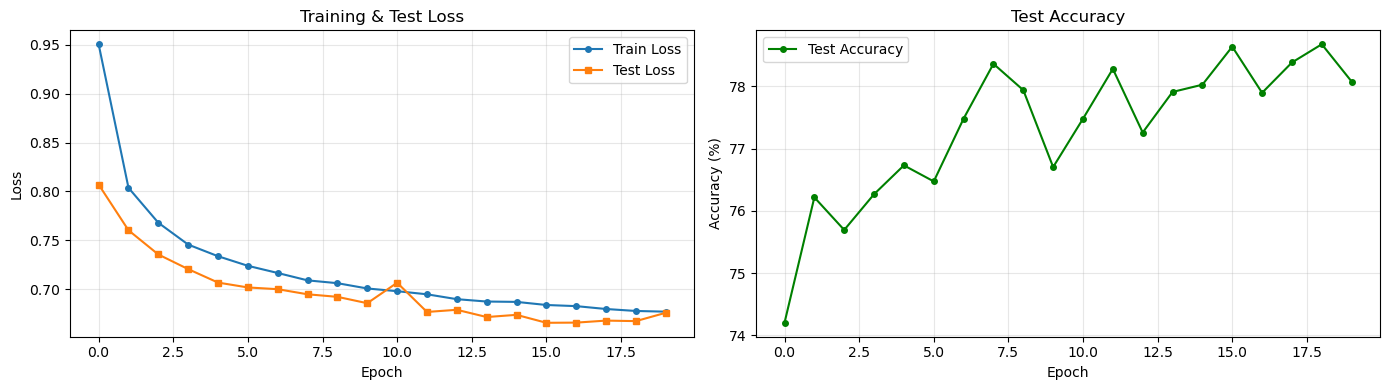

In [43]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', marker='o', markersize=4)
axes[0].plot(test_losses, label='Test Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(test_accuracies, label='Test Accuracy', marker='o', markersize=4, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: Extract Penultimate Layer Embeddings

We'll create a modified forward pass that extracts the 32-dimensional embeddings from `fc3` (the penultimate layer before classification).

In [44]:
def get_embeddings(model, data_loader, device):
    """Extract penultimate layer embeddings (fc3 output) from the model."""
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            
            # Forward pass through layers up to fc3 (penultimate layer)
            x = torch.relu(model.fc1(X_batch))
            x = model.dropout(x)
            x = torch.relu(model.fc2(x))
            x = model.dropout(x)
            x = torch.relu(model.fc3(x))  # This is the 32-dim embedding we want
            
            embeddings.append(x.cpu())
            labels.append(y_batch)
    
    embeddings = torch.cat(embeddings, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    return embeddings, labels

print("📊 Extracting embeddings from test set...")
test_embeddings, test_labels = get_embeddings(model, test_loader, device)
print(f"✅ Extracted embeddings shape: {test_embeddings.shape}")
print(f"   Embedding dimension: {test_embeddings.shape[1]}")
print(f"   Number of samples: {test_embeddings.shape[0]:,}")

📊 Extracting embeddings from test set...


✅ Extracted embeddings shape: (51535, 32)
   Embedding dimension: 32
   Number of samples: 51,535


## Step 5: Run UMAP on Model Embeddings

In [45]:
import umap.umap_ as umap

# Subsample for faster visualization if needed
max_points = 50_000
rng = np.random.default_rng(42)

if test_embeddings.shape[0] > max_points:
    idx = rng.choice(test_embeddings.shape[0], size=max_points, replace=False)
    emb_vis = test_embeddings[idx]
    labels_vis = test_labels[idx]
else:
    emb_vis = test_embeddings
    labels_vis = test_labels

print(f"🗺️ Running UMAP on {emb_vis.shape[0]:,} embeddings...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = reducer.fit_transform(emb_vis)
print(f"✅ UMAP complete! Shape: {umap_embeddings.shape}")

🗺️ Running UMAP on 50,000 embeddings...


✅ UMAP complete! Shape: (50000, 2)


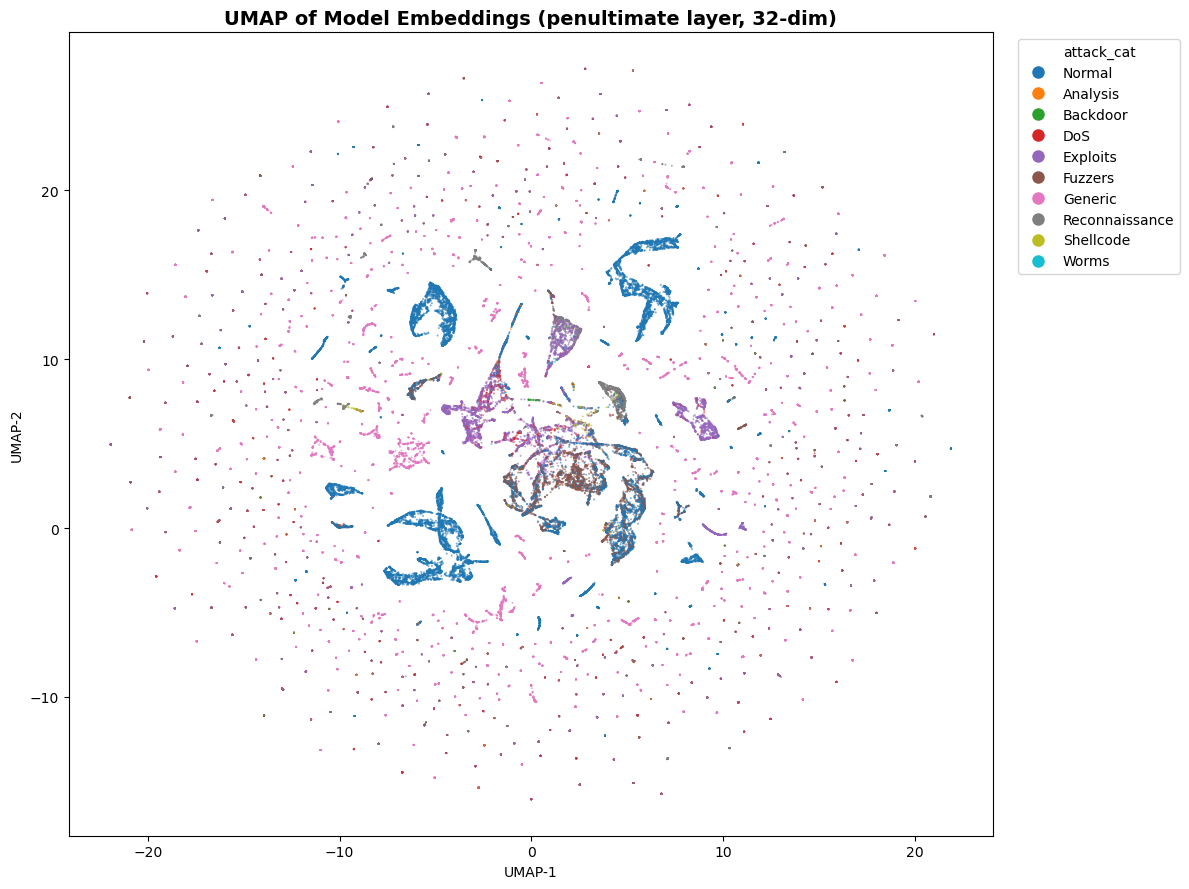

Visualized 50,000 points from TEST set


In [46]:
# Visualize UMAP of model embeddings
plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=labels_vis,
    cmap='tab10',
    s=2,
    alpha=0.6,
    linewidths=0,
)
plt.title("UMAP of Model Embeddings (penultimate layer, 32-dim)", fontsize=14, fontweight='bold')
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# Build legend
handles = []
for cls in sorted(np.unique(labels_vis)):
    cls_int = int(cls)
    label = inv_label_map.get(cls_int, str(cls_int)) if inv_label_map else str(cls_int)
    color = plt.cm.tab10(cls_int % 10)
    handles.append(
        mlines.Line2D([], [], color=color, marker="o", linestyle="None", markersize=8, label=label)
    )
plt.legend(handles=handles, title="attack_cat", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

print(f"Visualized {emb_vis.shape[0]:,} points from TEST set")

## Step 6: Run UMAP on Raw Features (for comparison)

In [47]:
# Use the same subsampled indices for fair comparison
X_test_np = X_test.numpy()

if X_test_np.shape[0] > max_points:
    # Use same indices as before
    X_raw_vis = X_test_np[idx]
    y_raw_vis = y_test.numpy()[idx]
else:
    X_raw_vis = X_test_np
    y_raw_vis = y_test.numpy()

print(f"🗺️ Running UMAP on {X_raw_vis.shape[0]:,} raw feature vectors ({X_raw_vis.shape[1]}-dim)...")
reducer_raw = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_raw = reducer_raw.fit_transform(X_raw_vis)
print(f"✅ UMAP complete! Shape: {umap_raw.shape}")

🗺️ Running UMAP on 50,000 raw feature vectors (71-dim)...


✅ UMAP complete! Shape: (50000, 2)


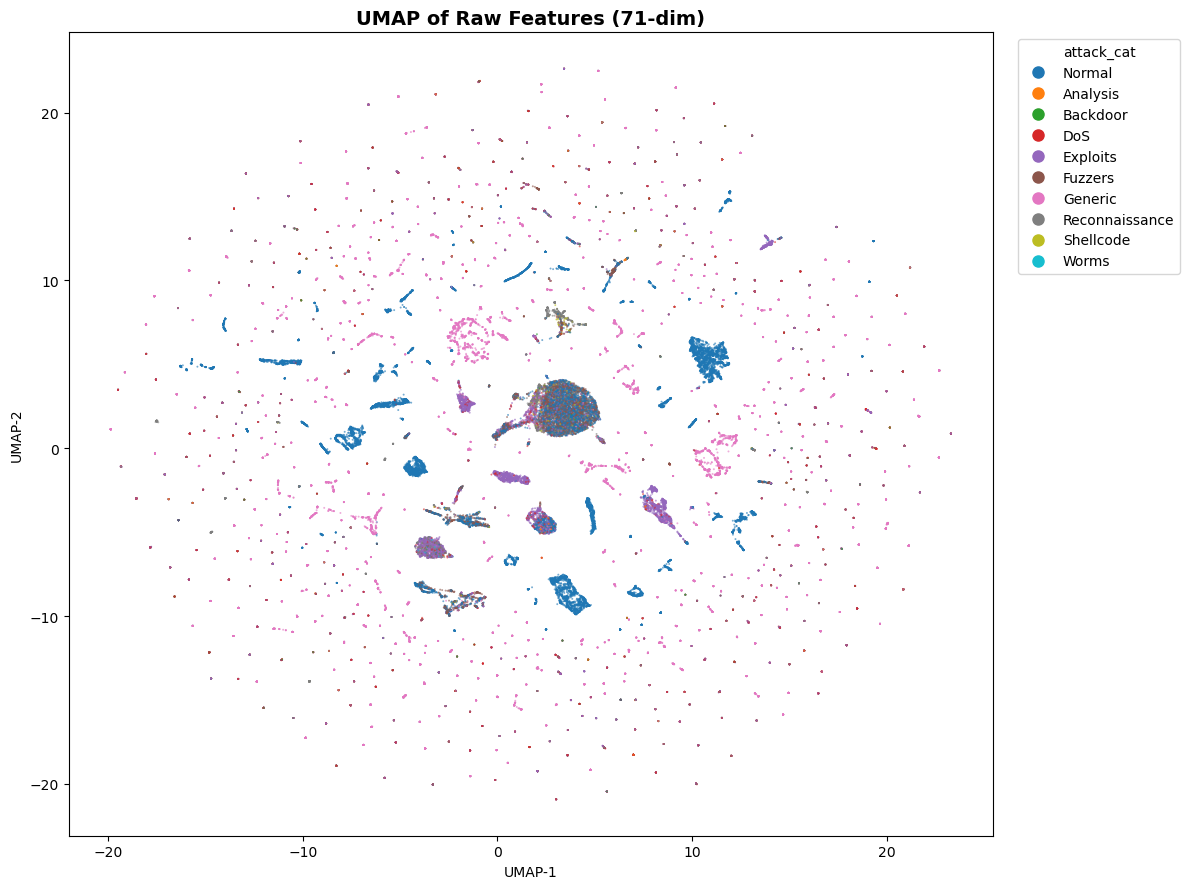

Visualized 50,000 points from TEST set


In [48]:
# Visualize UMAP of raw features
plt.figure(figsize=(12, 9))
scatter = plt.scatter(
    umap_raw[:, 0],
    umap_raw[:, 1],
    c=y_raw_vis,
    cmap='tab10',
    s=2,
    alpha=0.6,
    linewidths=0,
)
plt.title("UMAP of Raw Features (71-dim)", fontsize=14, fontweight='bold')
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

# Build legend
handles = []
for cls in sorted(np.unique(y_raw_vis)):
    cls_int = int(cls)
    label = inv_label_map.get(cls_int, str(cls_int)) if inv_label_map else str(cls_int)
    color = plt.cm.tab10(cls_int % 10)
    handles.append(
        mlines.Line2D([], [], color=color, marker="o", linestyle="None", markersize=8, label=label)
    )
plt.legend(handles=handles, title="attack_cat", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

print(f"Visualized {X_raw_vis.shape[0]:,} points from TEST set")

## Step 7: Side-by-Side Comparison

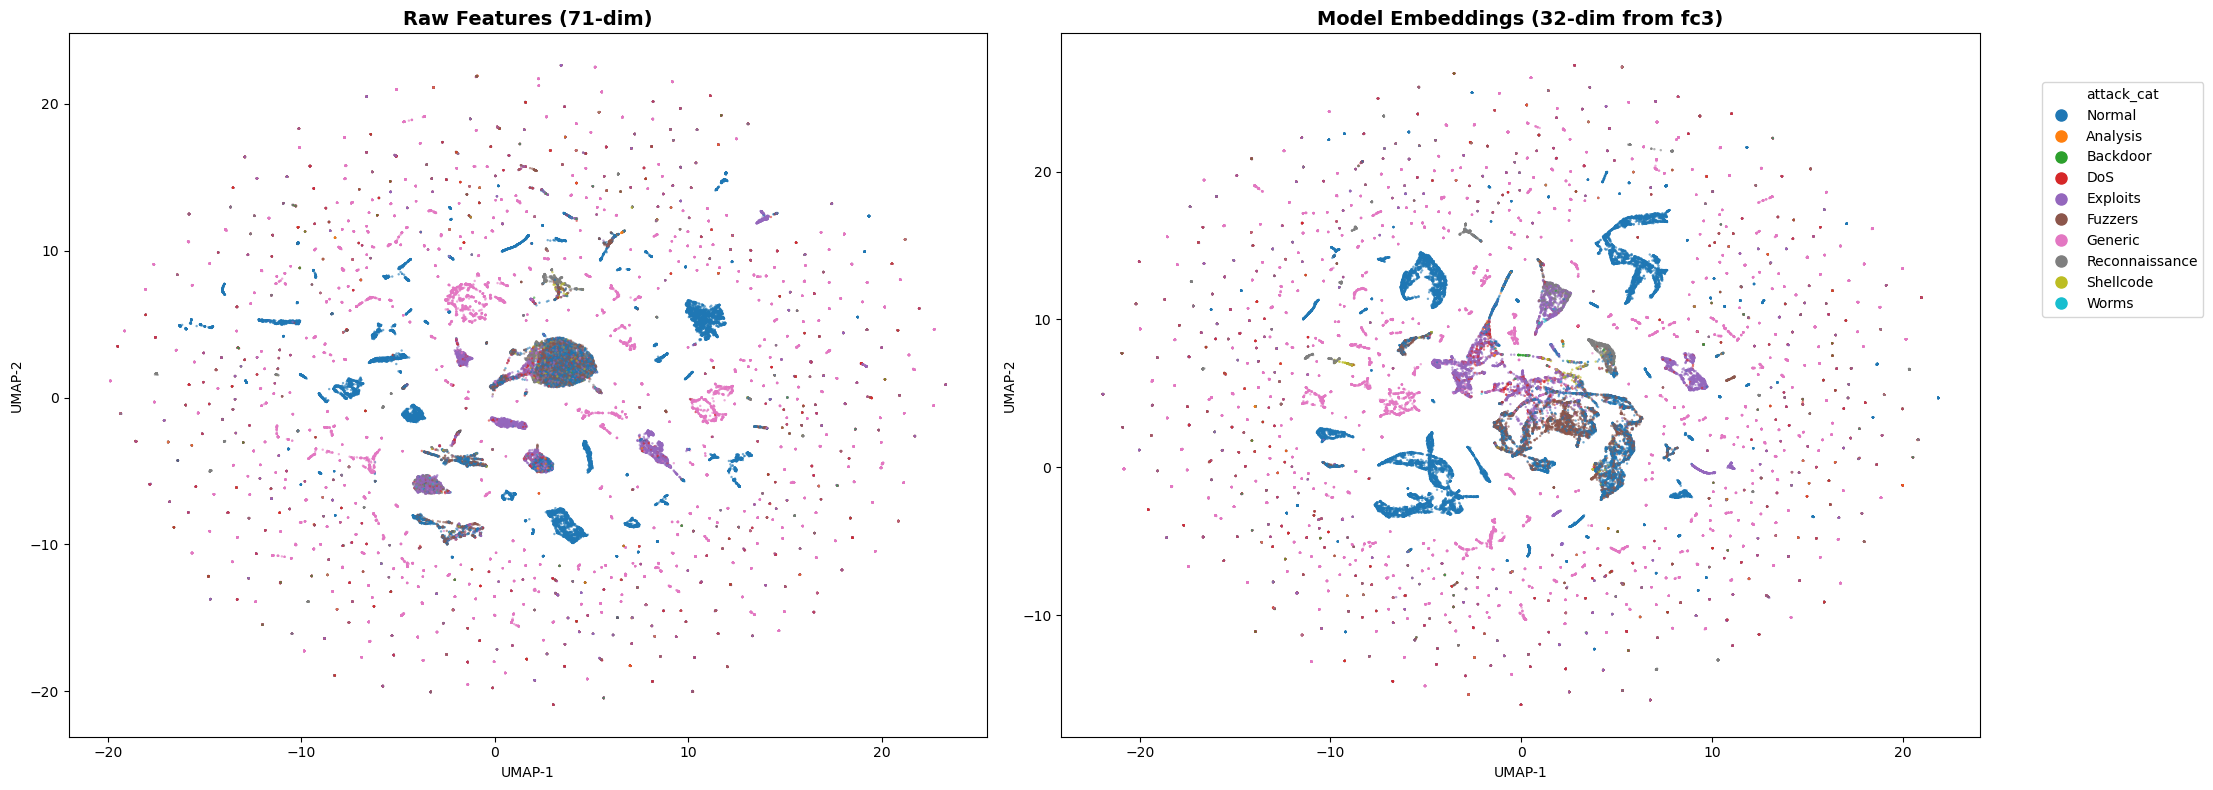


📊 Comparison Summary:
  - Raw features: 71 dimensions → UMAP 2D
  - Model embeddings: 32 dimensions → UMAP 2D
  - Number of samples: 50,000
  - Model test accuracy: 78.08%


In [49]:
# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Left: Raw features
axes[0].scatter(
    umap_raw[:, 0],
    umap_raw[:, 1],
    c=y_raw_vis,
    cmap='tab10',
    s=3,
    alpha=0.6,
    linewidths=0,
)
axes[0].set_title("Raw Features (71-dim)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("UMAP-1")
axes[0].set_ylabel("UMAP-2")

# Right: Model embeddings
axes[1].scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=labels_vis,
    cmap='tab10',
    s=3,
    alpha=0.6,
    linewidths=0,
)
axes[1].set_title("Model Embeddings (32-dim from fc3)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("UMAP-1")
axes[1].set_ylabel("UMAP-2")

# Shared legend
handles = []
for cls in sorted(np.unique(labels_vis)):
    cls_int = int(cls)
    label = inv_label_map.get(cls_int, str(cls_int)) if inv_label_map else str(cls_int)
    color = plt.cm.tab10(cls_int % 10)
    handles.append(
        mlines.Line2D([], [], color=color, marker="o", linestyle="None", markersize=8, label=label)
    )
fig.legend(handles=handles, title="attack_cat", bbox_to_anchor=(1.02, 0.9), loc="upper left")

plt.tight_layout()
plt.show()

print("\n📊 Comparison Summary:")
print(f"  - Raw features: {X_raw_vis.shape[1]} dimensions → UMAP 2D")
print(f"  - Model embeddings: {emb_vis.shape[1]} dimensions → UMAP 2D")
print(f"  - Number of samples: {emb_vis.shape[0]:,}")
print(f"  - Model test accuracy: {test_accuracies[-1]:.2f}%")

## (Optional) Save the Trained Model

Uncomment the cell below if you want to save the trained model for future use.

In [50]:
# Uncomment to save the model
# model_save_path = Path("notebooks/unsw_nb15_model_m7_moderate_weights.pth")
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'config': config,
#     'test_accuracy': test_accuracies[-1],
#     'label_map': label_map,
# }, model_save_path)
# print(f"💾 Model saved to {model_save_path}")